In [6]:
# 1. Lecture du fichier OFF
def read_off(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    assert lines[0].strip() == "OFF", "Format OFF non reconnu."
    nv, nf, _ = map(int, lines[1].split())
    vertices = [tuple(map(float, l.split())) for l in lines[2:2+nv]]
    faces = [tuple(map(int, l.split()[1:])) for l in lines[2+nv:2+nv+nf]]
    return vertices, faces

# 2. Construction du SimplicialComplex
vertices, faces = read_off('tore.off')
K = SimplicialComplex(faces)


In [9]:
K.homology(reduced=False)
# → {0: Z, 1: Z x Z, 2: Z}


{0: Z, 1: Z x Z, 2: Z}

In [10]:
# Subdivision barycentrique
K_sub = K.barycentric_subdivision()

# Vérification de la stabilité des groupes
K_sub.homology(reduced=False)


{0: Z, 1: Z x Z, 2: Z}

In [15]:
# Construction du chain comple
C = K.chain_complex()

# Calcul de H1 avec générateurs
H1_pairs = C.homology(1, generators=True)

# Boucle sur chaque facteur libre/torseur et sa chaîne génératrice
for (factor, chain) in H1_pairs:
    print("Facteur de H1 :", factor)          # e.g. C3 ou Z
    coords = chain.vector(1)                  # tuple des coefficients en degré 1
    print("Chaîne (vecteur) :", coords)



Facteur de H1 : Z
Chaîne (vecteur) : (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [29]:
edges = K._n_cells_sorted(1)

In [36]:
cycles = [chain for (_factor, chain) in H1_pairs]  
# cycles est maintenant une liste de 2 Chain

In [39]:
import numpy as np
import pyvista as pv

# A. Préparer les points et faces pour le tore
verts = np.array(vertices)                           
faces_pv = np.hstack([np.full((len(faces),1), 3),     
                      np.array(faces)]).flatten()

mesh_base = pv.PolyData(verts, faces=faces_pv)         

# B. Transformer chaque cycle en un PolyData de lignes
points = []
lines  = []
for k, chain in enumerate(cycles):
    vec = chain.vector(1)     # tuple des coefficients
    for idx, coeff in enumerate(vec):
        if coeff != 0:
            i, j = edges[idx]   # indices des deux sommets de l'arête
            points.extend([verts[i], verts[j]])
            # chaque segment commence par '2' suivi des indices des points
            # len(points)-2 et len(points)-1 sont les deux nouveaux points
            lines.extend([2, len(points)-2, len(points)-1])

points = np.array(points)
lines  = np.array(lines)
cycle_mesh = pv.PolyData(points, lines=lines)          # meshe de lignes 



In [40]:
p = pv.Plotter()
p.add_mesh(mesh_base, opacity=0.3)                     # tore en gris translucide 
p.add_mesh(cycle_mesh, line_width=5, color='red')      # cycles 
p.show()                                             


In [55]:
import time                                     
from sage.all import SimplicialComplex        

K = SimplicialComplex(faces)                  

# --- 2) Boucle de subdivisions et mesures ---
K_sub = K                                       # on part du complexe original
results = []                                    # liste pour stocker (itération, H, durée)

for k in range(0, 3):                           # par exemple 5 itération

    # 2.b) mesure du temps pour le calcul de l’homologie non réduite
    t0 = time.perf_counter()                   
    H = K_sub.homology(reduced=False)          # calcule H0,H1,H2 
    t1 = time.perf_counter()
    
    # 2.c) stockage et affichage
    duration = t1 - t0
    results.append((k, H, duration))
    print(f"{k} subdivisions → H = {H}, temps = {duration:.4f}s")
    #subdivision barycentrique
    # refine le complexe
    K_sub = K_sub.barycentric_subdivision() 


0 subdivisions → H = {0: Z, 1: Z x Z, 2: Z}, temps = 0.4257s
1 subdivisions → H = {0: Z, 1: Z x Z, 2: Z}, temps = 21.5199s
2 subdivisions → H = {0: Z, 1: Z x Z, 2: Z}, temps = 2392.0713s


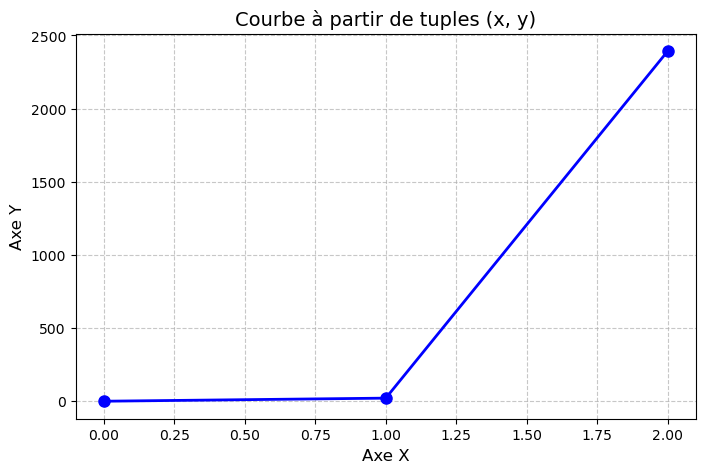

In [69]:
import matplotlib.pyplot as plt

# Séparation des coordonnées x et y
x = [point[0] for point in results]
y = [point[2] for point in results]

# Création du graphique
plt.figure(figsize=(8, 5)) 
plt.plot(x, y, 'bo-', linewidth=2, markersize=8) 
plt.title("Courbe à partir de tuples (x, y)", fontsize=14)
plt.xlabel("Axe X", fontsize=12)
plt.ylabel("Axe Y", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7) 
plt.show()

In [70]:
with open('time.txt', 'w') as f:
    for i in range(0,2):
            f.write("calcul des groupes d homologie de la" + str(x[i]) + "eme subdvision barycentrique met" + str(y[i]) + " seconde" '\n')

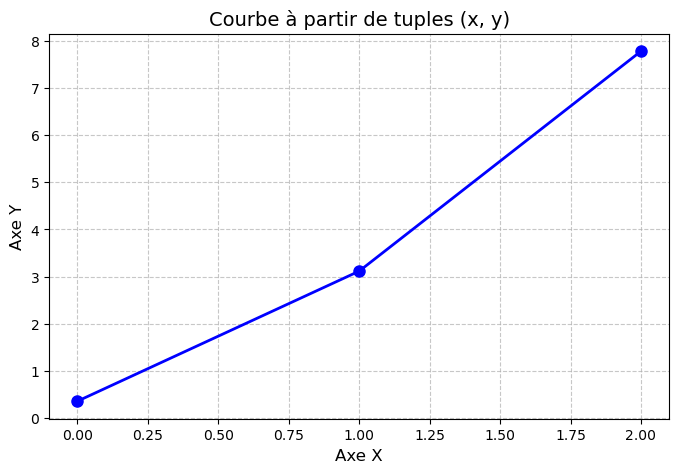

In [68]:
#en prenant y=log(1 + y) on a
import matplotlib.pyplot as plt

# Séparation des coordonnées x et y
x = [point[0] for point in results]
y = [log(1+ point[2]) for point in results]

# Création du graphique
plt.figure(figsize=(8, 5)) 
plt.plot(x, y, 'bo-', linewidth=2, markersize=8) 
plt.title("Courbe à partir de tuples (x, y)", fontsize=14)
plt.xlabel("Axe X", fontsize=12)
plt.ylabel("Axe Y", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7) 
plt.show()